In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage.feature import hog
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

2024-10-29 15:31:12.622111: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 15:31:12.623447: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-29 15:31:12.653192: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-29 15:31:12.681796: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730190672.739153   57465 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730190672.74

In [2]:
# def load_images_from_folder(folder, num_labels=500, num_images_per_label=50, image_size=(64, 64)):
#     images = []
#     labels = []
#     label_count = 0
    
#     for subdir in os.listdir(folder):
#         if label_count >= num_labels:
#             break
        
#         subdir_path = os.path.join(folder, subdir)
#         if os.path.isdir(subdir_path):
#             image_count = 0
#             for filename in os.listdir(subdir_path):
#                 if image_count >= num_images_per_label:
#                     break
                
#                 img_path = os.path.join(subdir_path, filename)
#                 img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Baca gambar dalam grayscale
#                 if img is not None:
#                     img = cv2.resize(img, image_size)  # Ubah ukuran gambar
#                     images.append(img)
#                     labels.append(label_count)
#                     image_count += 1
#             label_count += 1

#     return np.array(images), np.array(labels)

# # Load images and labels
# folder_path = "casia-webface"
# images, labels = load_images_from_folder(folder_path)
# print(images.shape)

In [3]:
import os
import shutil
import cv2
import numpy as np

def filter_classes_with_more_than_500_images(src_folder, dest_folder, min_images_per_class=500):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    
    filtered_classes = []
    for class_dir in os.listdir(src_folder):
        class_path = os.path.join(src_folder, class_dir)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            if num_images > min_images_per_class:
                filtered_classes.append(class_dir)
                dest_class_dir = os.path.join(dest_folder, class_dir)
                os.makedirs(dest_class_dir, exist_ok=True)
                for img_file in os.listdir(class_path):
                    src_img = os.path.join(class_path, img_file)
                    dest_img = os.path.join(dest_class_dir, img_file)
                    os.link(src_img, dest_img)  # Use os.link for fast linking instead of copying

    print(f"Classes with more than {min_images_per_class} images: {len(filtered_classes)}")

def load_images_from_folder(folder, image_size=(64, 64)):
    images = []
    labels = []
    label_count = 0
    
    for subdir in os.listdir(folder):
        subdir_path = os.path.join(folder, subdir)
        if os.path.isdir(subdir_path):
            for filename in os.listdir(subdir_path):
                img_path = os.path.join(subdir_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
                if img is not None:
                    img = cv2.resize(img, image_size)  # Resize image
                    images.append(img)
                    labels.append(label_count)
            label_count += 1

    return np.array(images), np.array(labels)

# Paths
src_folder = "casia-webface"
filtered_folder = "filtered5_casia_webface"

# Step 1: Filter classes with more than 500 images into a new directory
filter_classes_with_more_than_500_images(src_folder, filtered_folder)

# Step 2: Load images and labels from the filtered directory
images, labels = load_images_from_folder(filtered_folder)
print(images.shape)

Classes with more than 500 images: 27
(16018, 64, 64)


In [4]:
# Normalize pixel values to [0, 1] range
images = images / 255.0

# Standard scaling
scaler = StandardScaler()
images = scaler.fit_transform(images.reshape(-1, images.shape[-1])).reshape(images.shape)

# Split data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(12814, 64, 64) (3204, 64, 64) (12814,) (3204,)


In [5]:
# def apply_pca(images, n_components=50):
#     pca = PCA(n_components=n_components)
#     # Flatten images for PCA
#     flattened_images = [img.flatten() for img in images]
#     pca_features = pca.fit_transform(flattened_images)
#     return pca, pca_features

# # Apply PCA on train and test images
# pca, X_train_pca = apply_pca(X_train)
# X_test_pca = pca.transform([img.flatten() for img in X_test])

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define a function to apply PCA with a specified n_components
def apply_pca(images, n_components):
    # Standardize images
    scaler = StandardScaler()
    flattened_images = [img.flatten() for img in images]
    standardized_images = scaler.fit_transform(flattened_images)
    
    # Apply PCA with optimal n_components
    pca = PCA(n_components=n_components)
    pca_features = pca.fit_transform(standardized_images)
    return pca, pca_features

# Define a pipeline for PCA with standardization
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA())
])

# Define a parameter grid for GridSearchCV
param_grid = {
    'pca__n_components': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}

# Use GridSearchCV to find the best n_components
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
flattened_X_train = [img.flatten() for img in X_train]
grid_search.fit(flattened_X_train, y_train)

# Get the best n_components from GridSearchCV
best_n_components = grid_search.best_params_['pca__n_components']

# Use the best n_components in the apply_pca function
pca, X_train_pca = apply_pca(X_train, n_components=best_n_components)
X_test_pca = pca.transform([img.flatten() for img in X_test])

# Print the best n_components
print("The best number of PCA components is:", best_n_components)


The best number of PCA components is: 100


In [7]:
def extract_hog_features(images, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    hog_features = []
    for image in images:
        features = hog(image, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, orientations=orientations, block_norm='L2-Hys')
        hog_features.append(features)
    return np.array(hog_features)

# Apply HOG on train and test images
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

In [8]:
# from skimage.feature import hog
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC
# from sklearn.pipeline import Pipeline
# import numpy as np
# from sklearn.preprocessing import FunctionTransformer

# def extract_hog_features(images, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
#     hog_features = []
#     for image in images:
#         features = hog(image, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, orientations=orientations, block_norm='L2-Hys')
#         hog_features.append(features)
#     return np.array(hog_features)

# # Define a function to extract HOG features for grid search
# def hog_feature_extractor(images, pixels_per_cell, cells_per_block, orientations):
#     return extract_hog_features(images, pixels_per_cell, cells_per_block, orientations)

# # Define a pipeline for HOG feature extraction and classification
# pipeline = Pipeline([
#     ('hog', FunctionTransformer(hog_feature_extractor, validate=False, kw_args={'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2), 'orientations': 9})),
#     ('clf', SVC())
# ])

# # Define a parameter grid for GridSearchCV
# param_grid = {
#     'hog__kw_args': [
#         {'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2), 'orientations': 9},
#         {'pixels_per_cell': (16, 16), 'cells_per_block': (2, 2), 'orientations': 9},
#         {'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2), 'orientations': 12},
#     ]
# }

# # Use GridSearchCV to find the best HOG parameters
# grid_search = GridSearchCV(pipeline, param_grid, cv=5)
# grid_search.fit(X_train, y_train)

# # Get the best HOG parameters
# best_hog_params = grid_search.best_params_['hog__kw_args']

# # Apply the best HOG parameters on train and test images
# X_train_hog = extract_hog_features(X_train, **best_hog_params)
# X_test_hog = extract_hog_features(X_test, **best_hog_params)

In [9]:
# # Ensure best_hog_params is defined before using it
# print(f"Best HOG parameters: {best_hog_params}")

In [10]:
# Concatenate PCA and HOG features
X_train_features = np.hstack([X_train_pca, X_train_hog])
X_test_features = np.hstack([X_test_pca, X_test_hog])

print(X_train_features.shape, X_test_features.shape)

(12814, 1864) (3204, 1864)


In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.utils import to_categorical
import numpy as np

# Normalize the features
X_train_features = X_train_features / np.max(X_train_features, axis=0)
X_test_features = X_test_features / np.max(X_test_features, axis=0)

# One-hot encode labels
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

# Define the model architecture
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_features.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(y_train_encoded.shape[1], activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

# Train the model
history = model.fit(X_train_features, y_train_encoded, epochs=50, batch_size=32, validation_data=(X_test_features, y_test_encoded), callbacks=[lr_scheduler])

/home/doni/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-10-29 15:42:42.408669: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.0696 - loss: 3.9057 - val_accuracy: 0.2940 - val_loss: 2.4612 - learning_rate: 0.0010
Epoch 2/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.2170 - loss: 2.7136 - val_accuracy: 0.4600 - val_loss: 1.8664 - learning_rate: 0.0010
Epoch 3/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3454 - loss: 2.2486 - val_accuracy: 0.5730 - val_loss: 1.5002 - learning_rate: 0.0010
Epoch 4/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4291 - loss: 1.9628 - val_accuracy: 0.6024 - val_loss: 1.4110 - learning_rate: 0.0010
Epoch 5/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4845 - loss: 1.7950 - val_accuracy: 0.6483 - val_loss: 1.2292 - learning_rate: 0.0010
Epoch 6/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5440 - loss: 1.5998 - val_accuracy: 0.6604 - val_loss: 1.2001 - learning_rate: 0.0010
Epoch 7/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5651 - loss: 1.5306

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 76.62%
Precision: 77.60%
Recall: 76.69%
F1 Score: 76.60%
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7548 - loss: 0.9849
Validation Accuracy: 76.62%


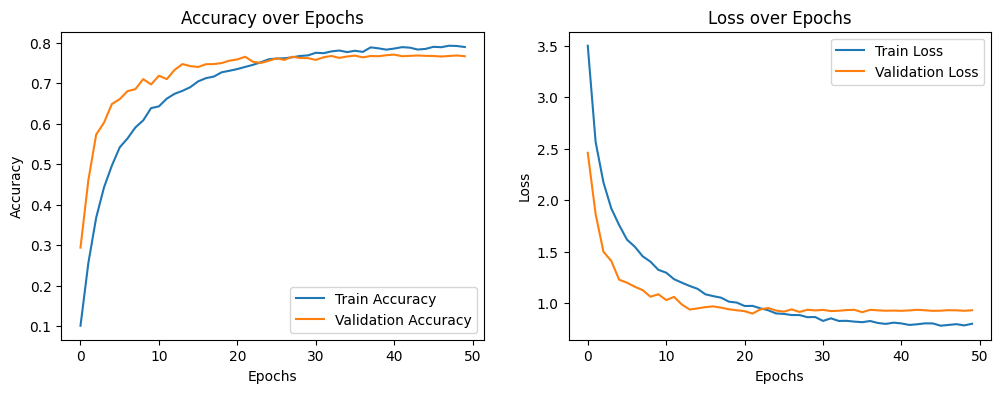

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict classes on the test set
y_pred_classes = np.argmax(model.predict(X_test_features), axis=1)

# Calculate metrics and display accuracy in percentage
accuracy = accuracy_score(y_test, y_pred_classes) * 100
precision = precision_score(y_test, y_pred_classes, average='macro') * 100
recall = recall_score(y_test, y_pred_classes, average='macro') * 100
f1 = f1_score(y_test, y_pred_classes, average='macro') * 100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(X_test_features, y_test_encoded)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()